Alex Mei \\
CS 165B \\
Fall 2021 \\

In [ ]:
# Imports
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import math
import time

In [ ]:
# Constants
IMAGE_DIM = 16
TRAIN_DATASIZE = 1561
PARTITIONS = 4
PARTITION_SIZE = TRAIN_DATASIZE / PARTITIONS

In [ ]:
# Q3 Load Data
train_data = np.load("train_data.npy")
test_data = np.load("test_data.npy")
train_labels = np.load("train_labels.npy")
test_labels = np.load("test_labels.npy")
print("Training Data Shape:", np.shape(train_data))
print("Training Label Shape:", np.shape(train_labels))
print("Testing Data Shape:", np.shape(test_data))
print("Testing Label Shape:", np.shape(test_labels)) 

Training Data Shape: (1561, 256)
Training Label Shape: (1561,)
Testing Data Shape: (424, 256)
Testing Label Shape: (424,)


In [ ]:
def plotImage(dataSample: np.array) -> None:
  plt.figure()  
  plt.imshow(np.reshape(dataSample, (IMAGE_DIM, IMAGE_DIM)), cmap='binary')  
  plt.show()

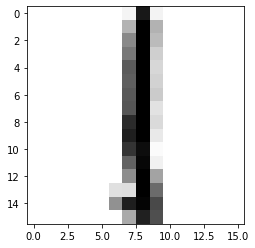

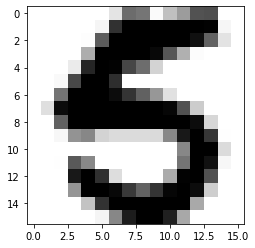

In [ ]:
# Q3a Plot Images
plotImage(train_data[1])
plotImage(train_data[1500])

In [ ]:
def featureIntensity(dataSample: np.array) -> float:
  return np.mean(dataSample)

def featureSymmetry(dataSample: np.array) -> float:
  return np.mean([abs(dataSample[i] - dataSample[IMAGE_DIM * ((IMAGE_DIM - i - 1) // IMAGE_DIM) + i % IMAGE_DIM]) for i in range(len(dataSample))])


In [ ]:
# Separate into Pos, Neg labels with extracted features
def extractFeatures(dataset: np.array, labels: np.array) -> tuple:
  positiveExamples = list()
  negativeExamples = list()

  for index, label in enumerate(labels):
    if label == 1:
      positiveExamples.append(dataset[index])
    else:
      negativeExamples.append(dataset[index])

  return (np.array([[1, featureIntensity(dataSample),featureSymmetry(dataSample)] for dataSample in positiveExamples]), 
          np.array([[1, featureIntensity(dataSample),featureSymmetry(dataSample)] for dataSample in negativeExamples]))
  


In [ ]:
# Q3b Feature Extraction
posTrainingData, negTrainingData = extractFeatures(train_data, train_labels)
posTestingData, negTestingData = extractFeatures(test_data, test_labels)

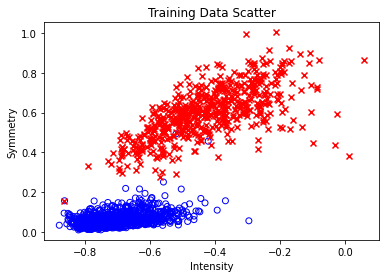

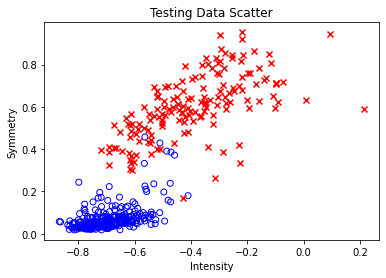

In [ ]:
# Q3c Scatterplots
# Train
plt.scatter(posTrainingData[:,1], posTrainingData[:,2], facecolors='none', color="blue")
plt.scatter(negTrainingData[:,1], negTrainingData[:,2], marker="x", color="red")
plt.xlabel("Intensity")
plt.ylabel("Symmetry")
plt.title("Training Data Scatter")
plt.show()

# Test
plt.scatter(posTestingData[:,1], posTestingData[:,2], facecolors='none', color="blue")
plt.scatter(negTestingData[:,1], negTestingData[:,2], marker="x", color="red")
plt.xlabel("Intensity")
plt.ylabel("Symmetry")
plt.title("Testing Data Scatter")
plt.show()

In [ ]:
# Logistic Error
def errorFunction(weights: np.array, data: np.array, labels: np.array, regularization: float = 0):
  datasetSize = np.shape(data)[0]
  return sum([np.log(1 + np.exp(-labels[i]* weights.T @ data[i])) for i in range(datasetSize)]) / datasetSize + regularization * npla.norm(weights, 2) ** 2

In [ ]:
def sigmoidFunction(x: float) -> float:
  return 1 / (1 + np.exp(-x))

In [ ]:
def gradientDescentStep(
    weights: np.array, 
    data: np.array, 
    labels: np.array, 
    stepSize: float, 
    regularization: float = 0):
  datasetSize = np.shape(data)[0]

  # compute gradient and direction vector
  gradient = sum([-labels[i] * data[i] * sigmoidFunction(-labels[i] * weights.T @ data[i]) for i in range(datasetSize)]) / datasetSize
  gradient += 2 * regularization * weights
  direction = -1 * gradient 

  # return update weights
  return weights + stepSize * direction

In [ ]:
def gradientDescent(
    weights: np.array, 
    data: np.array, 
    labels: np.array, 
    stepSize: float, 
    maxIterations: int,
    granularity: int,
    regularization: float = 0):

  previousError = float("inf")

  for i in range(maxIterations):
    # update weights
    weights = gradientDescentStep(weights, data, labels, stepSize, regularization=regularization)

    # granularity of checking update
    if i % granularity == 1:
      error = errorFunction(weights, data, labels, regularization)

      # error threshold for early convergence
      if abs(previousError - error) < 0.00001:
        print("Converged after {} iterations".format(i))
        break

      previousError = error

  return weights

In [ ]:
# Q4 Gradient Descent for Logistic Regression

# hyperparameters
stepSize = 1               # learning rate
iterations = 10 ** 5        # maximum iterations
granularity = 100           # granularity of error checking

# Initialize Variables
transformedTrainData = np.concatenate((posTrainingData, negTrainingData))
transformedTrainLabels = np.array([1 for i in range(np.shape(posTrainingData)[0])] + [-1 for i in range(np.shape(negTrainingData)[0])])

transformedTestData = np.concatenate((posTestingData, negTestingData))
transformedTestLabels = np.array([1 for i in range(np.shape(posTestingData)[0])] + [-1 for i in range(np.shape(negTestingData)[0])]) 

# Run Gradient Descent
weights = np.ones(np.shape(posTestingData)[1])
trainedWeights = gradientDescent(weights, transformedTrainData, transformedTrainLabels, stepSize, iterations, granularity)

Converged after 22201 iterations


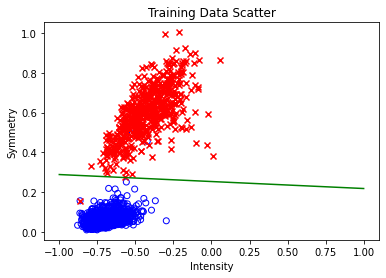

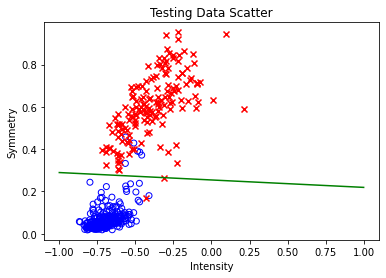

In [ ]:
# Q4a Linear Separator 
slope = -1 * trainedWeights[1] / trainedWeights[2]
intercept = -1 * trainedWeights[0] / trainedWeights[2]

# Plot Train
plt.plot([-1, 1], [-1 * slope + intercept, 1 * slope + intercept], color="green")
plt.scatter(posTrainingData[:,1], posTrainingData[:,2], facecolors='none', color="blue")
plt.scatter(negTrainingData[:,1], negTrainingData[:,2], marker="x", color="red")
plt.xlabel("Intensity")
plt.ylabel("Symmetry")
plt.title("Training Data Scatter")
plt.show()

# Plot Test
plt.plot([-1, 1], [-1 * slope + intercept, 1 * slope + intercept], color="green")
plt.scatter(posTestingData[:,1], posTestingData[:,2], facecolors='none', color="blue")
plt.scatter(negTestingData[:,1], negTestingData[:,2], marker="x", color="red")
plt.xlabel("Intensity")
plt.ylabel("Symmetry")
plt.title("Testing Data Scatter")
plt.show()

In [ ]:
# Q4b Error Rates
print("Training Error: {}".format(errorFunction(trainedWeights, transformedTrainData, transformedTrainLabels)))
print("Testing Error: {}".format(errorFunction(trainedWeights, transformedTestData, transformedTestLabels)))

Training Error: 0.016276322136481985
Testing Error: 0.07119894977417573


In [ ]:
def crossValidate(partitionedData: list, partitionedLabels: list, candidate: float) -> float:
  error = 0
  
  # Cross Validation on folding
  for validation in range(PARTITIONS):
    data = np.empty((0,3))
    labels = np.array([])

    for i in range(PARTITIONS):
      if i != validation:
        data = np.concatenate((data, partitionedData[i]), axis=0)
        labels = np.concatenate((labels, partitionedLabels[i]))

  # Run Gradient Descent
  weights = np.ones(np.shape(posTestingData)[1])
  trainedWeights = gradientDescent(weights, data, labels, stepSize, iterations, granularity, regularization=candidate)
  error += errorFunction(trainedWeights, partitionedData[validation], partitionedLabels[validation], regularization=candidate)

  return error / PARTITIONS

In [ ]:
# Q4c Logistic Regularization
# Randomize Partition
randomizedList = list(range(TRAIN_DATASIZE))
random.shuffle(randomizedList)

# Partition Data
partitionedData = [[transformedTrainData[j] for j in range(int(PARTITION_SIZE * i), int(PARTITION_SIZE * (i + 1)))] for i in range(PARTITIONS)]
partitionedLabels = [[transformedTrainLabels[j] for j in range(int(PARTITION_SIZE * i), int(PARTITION_SIZE * (i + 1)))] for i in range(PARTITIONS)]

# Cross Validate Candidates
candidates = [10 ** -6, 10 ** -5, 10 ** -4, 10 ** -3]
for candidate in candidates:
  print("Regularization term {} has {} cross validation error".format(candidate, crossValidate(partitionedData, partitionedLabels, candidate)))

Converged after 16501 iterations
Regularization term 1e-06 has 0.008699760494434883 cross validation error
Converged after 11401 iterations
Regularization term 1e-05 has 0.011520956902875322 cross validation error
Converged after 4101 iterations
Regularization term 0.0001 has 0.026731076852132864 cross validation error
Converged after 901 iterations
Regularization term 0.001 has 0.09047914951251218 cross validation error


In [ ]:
# 3rd Order Polynomial Transform
def transform(data: np.array) -> np.array:
  newData = np.ones((np.shape(data)[0], 10))

  # Original Data
  newData[:,:3] = data

  # 2nd Order
  newData[:,3] = data[:,1] ** 2
  newData[:,4] = data[:,2] ** 2
  newData[:,5] = data[:,1] * data[:,2]

  # 3rd Order
  newData[:,6] = data[:,1] ** 3
  newData[:,7] = data[:,2] ** 3
  newData[:,8] = data[:,1] ** 2 * data[:,2]
  newData[:,9] = data[:,1] * data[:,2] ** 2

  return newData

In [ ]:
# Q4d 3rd Order Polynomial Transform
orderTransformTrainData = transform(transformedTrainData)
orderTransformTestData = transform(transformedTestData)

# Run Gradient Descent
weights = np.ones(np.shape(orderTransformTrainData)[1])
trainedWeights = gradientDescent(weights, orderTransformTrainData, transformedTrainLabels, stepSize, iterations, granularity)

# Error Rates
print("Training Error: {}".format(errorFunction(trainedWeights, orderTransformTrainData, transformedTrainLabels)))
print("Testing Error: {}".format(errorFunction(trainedWeights, orderTransformTestData, transformedTestLabels)))

Converged after 16501 iterations
Training Error: 0.015326810493627895
Testing Error: 0.0713816477667692
